In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

##### (評分指標)
from sklearn.metrics import roc_auc_score, confusion_matrix

##### 由多種方法組成，在各種迭代器中用於計算快速且代碼高效的解決方案
import itertools                        # 用在 confusion matrix

##### Progress bar (進度條)
from tqdm import tqdm

##### KFOLD
from sklearn.model_selection import KFold

##### preprocessing (預處理)
from sklearn.preprocessing import QuantileTransformer #分位數變壓器

##### preprocessing  (預處理)
from sklearn.preprocessing import QuantileTransformer 

**使用分位數信息轉換特徵**
```
此方法將特徵轉換為遵循均勻或正態分佈。
因此，對於給定的特徵，這種轉換往往會分散最常見的值。
它還減少了（邊際）異常值的影響：因此這是一個強大的預處理方案。

轉換獨立地應用於每個特徵。
首先，使用特徵的累積分佈函數的估計值將原始值映射到均勻分佈。
然後使用相關的分位數函數將獲得的值映射到所需的輸出分佈。
低於或高於擬合範圍的新/未見數據的特徵值將映射到輸出分佈的邊界。
請注意，此變換是非線性的。
它可能會扭曲以相同尺度測量的變量之間的線性相關性，
但會使以不同尺度測量的變量更直接地具有可比性。
```
參考:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html

# df.agg(), apply

### pandas.DataFrame.agg
```
axis : {0 或 'index'，1 或 'columns'}，默認 0
如果為 0 或“索引”：將函數應用於每一列。
如果為 1 或“列”：將函數應用於每一行。

```

### df.apply
```
axis=1 代表我們以行（Row）作單位，
而 0 代表我們以列（Column）作單位
```

In [2]:
df1 = pd.DataFrame([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9],
                   [np.nan, np.nan, np.nan]],
                  columns=['A', 'B', 'C'])

In [3]:
df1

,A,B,C
0,1.0,2.0,3.0
1,4.0,5.0,6.0
2,7.0,8.0,9.0
3,NaN,NaN,NaN


In [4]:
df1.agg(['sum', 'min'])

,A,B,C
sum,12.0,15.0,18.0
min,1.0,2.0,3.0


In [5]:
df1.agg({'A' : ['sum', 'min'], 'B' : ['min', 'max']})

,A,B
sum,12.0,NaN
min,1.0,2.0
max,NaN,8.0


In [6]:
#在列上聚合不同的函數並重命名結果 DataFrame 的索引

df1.agg(x=('A', max), y=('B', 'min'), z=('C', np.mean))

,A,B,C
x,7.0,NaN,NaN
y,NaN,2.0,NaN
z,NaN,NaN,6.0


In [9]:
x=np.random.rand(20)      # 隨機 20 個 0~1 的數，randn 是從 norm 中抽
float(stats.mode(x)[0])   # array --> float

0.09939564519961719

# XGBoost
參考 : https://www.codeprj.com/zh/blog/aaf0f81.html

In [2]:
# pip install xgboost

In [3]:
import xgboost as xgb  
from xgboost import XGBClassifier

In [4]:
# ?XGBClassifier

```python
xgb_params = {
    'eval_metric': 'auc',                     # 用於監控訓練結果和提前停止的指標
    'objective': 'binary:logistic', 
    'tree_method': 'gpu_hist', 
    'gpu_id': -1, 
    'predictor': 'gpu_predictor', 
    'n_estimators': 10000,                    # 樹的數量
    'learning_rate': 0.02,                    # 樹的學習率
    'gamma': 0.2465,                          # Loss function 下降的下界 (越大越保守)
    'max_depth': 4,                           # 預剪枝，樹的最大深度
    'min_child_weight': 366,                  # 預剪枝，樹的子結點最小樣本合
    'subsample': 0.6423,                      # 樣本抽樣比例
    'colsample_bytree': 0.775,                # 特徵抽樣比例
    'colsample_bylevel': 0.868,               # 結點使用特徵比例
    'lambda': 0.5,                            # L2正則懲罰項
    'alpha': 10,                              # L1正則懲罰項
    'random_state': 42,
    'use_label_encoder': False
}
```

In [5]:
xgb_params = {
    'eval_metric': 'auc',                     # 用於監控訓練結果和提前停止的指標
    'objective': 'binary:logistic', 
    'tree_method': 'gpu_hist', 
    'gpu_id': -1, 
    'predictor': 'gpu_predictor', 
    'n_estimators': 10000,                    # 樹的數量
    'learning_rate': 0.02,                    # 樹的學習率
    'gamma': 0.2465,                          # Loss function 下降的下界 (越大越保守)
    'max_depth': 4,                           # 預剪枝，樹的最大深度
    'min_child_weight': 366,                  # 預剪枝，樹的子結點最小樣本合
    'subsample': 0.6423,                      # 樣本抽樣比例
    'colsample_bytree': 0.775,                # 特徵抽樣比例
    'colsample_bylevel': 0.868,               # 結點使用特徵比例
    'lambda': 0.5,                            # L2正則懲罰項
    'alpha': 10,                              # L1正則懲罰項
    'random_state': 42,
    'use_label_encoder': False
}

# Light GBM

```python
gbm_params = {
    'metric' : 'auc',
    'objective' : 'binary',
    'device_type': 'gpu', 
    'n_estimators': 10000,                    # 樹的數量
    'learning_rate': 0.122,                   # 樹的學習率
    'num_leaves': 1400,                       # 預剪枝，葉子中樣本個數
    'max_depth': 8,                           # 預剪枝，樹的最大深度
    'min_child_samples': 300,                 # 預剪枝，同 (min_data_in_leaf)
    'reg_alpha': 10,                          # L1正則懲罰項
    'reg_lambda': 65,                         # L2正則懲罰項
    'min_split_gain': 5.158,                  # 預剪枝，信息增益的下界
    'subsample': 0.5,                         # 樣本抽樣比例
    'subsample_freq': 1,                      # 樣本抽樣頻率
    'colsample_bytree': 0.2,                  # 特徵抽樣比例
    'min_sum_hessian_in_leaf': 1e-3,          # 預剪枝，葉子的最小 hessian 值
    'random_state': 42
}
```

- dict_1 = { }     
- 使用大刮號 { } 創建字典
- dict_2 = dict( )

其他: https://selflearningsuccess.com/python-dictionary/

In [11]:
df = pd.read_csv(r"C:\Users\user\Desktop\2022data\df_add_na.csv", index_col='id')
# 第五種,用 NaN 數量 + 手動補值   
# df.isnull().sum().sum() # 0

<AxesSubplot:>

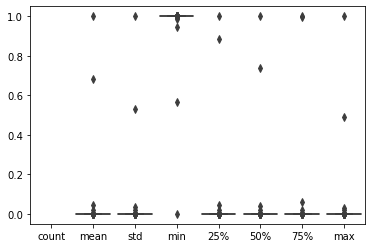

In [3]:
# 看各分位距分布

plot_df = df.describe(include='all').T
plot_df_ = (plot_df - plot_df.min())/(plot_df.max()-plot_df.min())
sns.boxplot(data=plot_df_)

# 因為每個 feature 造成的範圍太大，分母太大讓整個值趨近於 0

In [4]:
plot_df_

,count,mean,std,min,25%,50%,75%,max
f1,NaN,4.710876e-16,6.237278e-19,1.000000,3.683115e-13,1.051196e-15,1.073024e-16,1.265468e-18
f2,NaN,4.771488e-16,2.148648e-18,1.000000,3.690895e-13,1.072532e-15,1.139021e-16,1.584924e-18
f3,NaN,9.556783e-14,9.531167e-14,1.000000,1.916686e-12,9.237890e-14,8.361693e-14,1.216776e-13
f4,NaN,4.736868e-16,3.131860e-18,1.000000,3.681874e-13,1.054536e-15,1.107371e-16,4.049338e-18
f5,NaN,4.761701e-16,2.133864e-18,1.000000,3.689331e-13,1.068155e-15,1.130160e-16,1.694958e-18
...,...,...,...,...,...,...,...,...
f116,NaN,1.000000e+00,1.000000e+00,0.567674,8.868771e-01,1.000000e+00,9.985814e-01,1.000000e+00
f117,NaN,9.376698e-14,4.683528e-14,1.000000,5.200832e-12,2.314681e-13,1.176007e-13,4.046585e-14
f118,NaN,4.821418e-16,6.038689e-18,1.000000,3.690703e-13,1.078552e-15,1.193545e-16,8.430089e-18
Nanumber,NaN,5.138805e-16,3.028782e-17,1.000000,3.680564e-13,1.116140e-15,1.629736e-16,4.306623e-17


**移除離群值**<br>
**IQR:看百分位數(要是常態)** 
```
n=1.5
#IQR = Q3-Q1
IQR = np.percentile(df.iloc[:,1],75) - np.percentile(df.iloc[:,1],25)
# outlier = Q3 + n*IQR 
transform_data = df.iloc[:,1][df.iloc[:, 1] < np.percentile(df.iloc[:,1],75) + n*IQR]
# outlier = Q1 - n*IQR 
transform_data = transform_data[transform_data[:,] > np.percentile(df.iloc[:,1],25) - n*IQR]

transform_data #pandas.core.series.Series

```
**判斷離群值**
- cook D 
- Mahalanobis Distance 馬哈拉諾比斯距離

In [83]:
### 直接移

N_df = pd.DataFrame()  
IQR=0
n=1.5
for i in tqdm(range(119)):
    IQR = np.percentile(df.iloc[:,i],75) - np.percentile(df.iloc[:,i],25)                         # IQR = Q3-Q1
    transform_data = df.iloc[:,i][df.iloc[:, i] < np.percentile(df.iloc[:,i],75) + n*IQR]         # outlier = Q3 + n*IQR 
    transform_data = transform_data[transform_data[:,] > np.percentile(df.iloc[:,i],25) - n*IQR]  # outlier = Q1 - n*IQR 
    N_df = pd.concat((N_df, transform_data), axis = 'columns')     


100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [01:41<00:00,  1.17it/s]


In [84]:
N_df.isnull().sum()

f1           53240
f2           89463
f3          124231
f4           39085
f5               0
             ...  
f115         94084
f116        104148
f117             0
f118         40115
Nanumber     10182
Length: 119, dtype: int64

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:22<00:00,  4.13s/it]


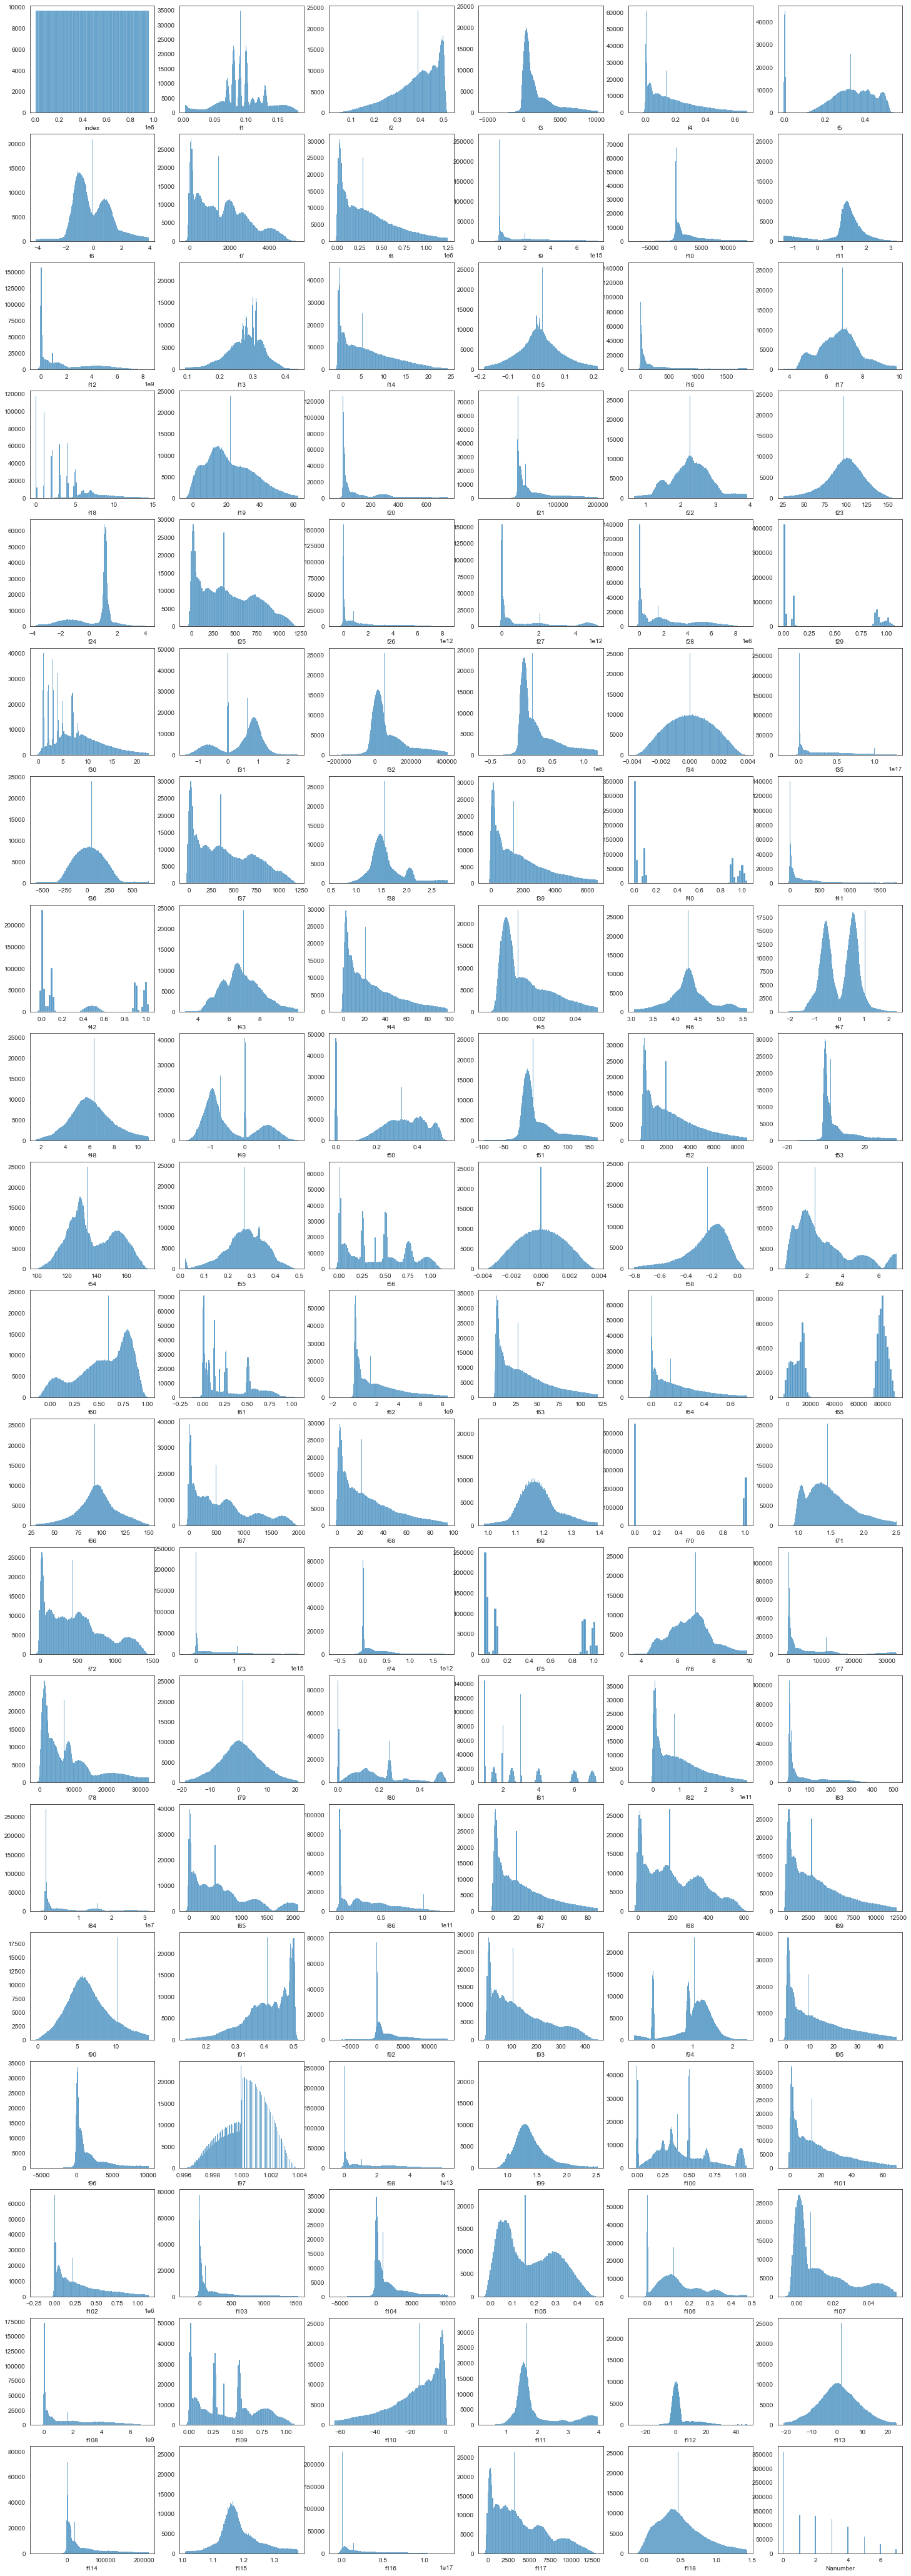

In [85]:
# 移完後分布

NROW=20
NCOL=6

i = 0
sns.set_style('white')
fig, ax = plt.subplots(NROW, NCOL, figsize = (25,75))
plot_df = N_df.reset_index()
for row in tqdm(range(NROW)):
    for col in range(NCOL):
        sns.histplot(data = plot_df.iloc[:,i], ax = ax[row, col], palette = 'bone_r').set(ylabel = '')
        i = i + 1

# palette 調色盤

# Fill with NA

In [37]:
train_df = pd.read_csv(r"C:\Users\user\Desktop\2022data\train.csv", index_col=0)
test_df = pd.read_csv(r"C:\Users\user\Desktop\2022data\test.csv", index_col=0)

In [38]:
# train_df is your trianing dataframe (pd.read_csv('training_path'))
# test_df is your testing dataframe (pd.read_csv('testing_path'))
 
fill_config = {
    'f1': 'Mean', 
    'f2': 'Mean', 
    'f3': 'Mode', 
    'f4': 'Mode', 
    'f5': 'Mode', 
    'f6': 'Mean', 
    'f7': 'Mean', 
    'f8': 'Median', 
    'f9': 'Mode', 
    'f10': 'Mode', 
    'f11': 'Mode', 
    'f12': 'Median', 
    'f13': 'Mode', 
    'f14': 'Median', 
    'f15': 'Mean', 
    'f16': 'Median', 
    'f17': 'Mode', 
    'f18': 'Median', 
    'f19': 'Median', 
    'f20': 'Median', 
    'f21': 'Median', 
    'f22': 'Mean', 
    'f23': 'Mode', 
    'f24': 'Median', 
    'f25': 'Median', 
    'f26': 'Median', 
    'f27': 'Median', 
    'f28': 'Median', 
    'f29': 'Mean', 
    'f30': 'Median', 
    'f31': 'Mode', 
    'f32': 'Median', 
    'f33': 'Median', 
    'f34': 'Mean', 
    'f35': 'Median', 
    'f36': 'Median', 
    'f37': 'Median', 
    'f38': 'Mode', 
    'f39': 'Median', 
    'f40': 'Mean', 
    'f41': 'Median', 
    'f42': 'Mean', 
    'f43': 'Mode', 
    'f44': 'Median', 
    'f45': 'Median', 
    'f46': 'Mean', 
    'f47': 'Mean', 
    'f48': 'Median', 
    'f49': 'Mode', 
    'f50': 'Mean', 
    'f51': 'Median', 
    'f52': 'Median', 
    'f53': 'Median', 
    'f54': 'Median', 
    'f55': 'Mode', 
    'f56': 'Mean', 
    'f57': 'Mean', 
    'f58': 'Median', 
    'f59': 'Median', 
    'f60': 'Mode', 
    'f61': 'Mode', 
    'f62': 'Median', 
    'f63': 'Median', 
    'f64': 'Median', 
    'f65': 'Mean', 
    'f66': 'Mode', 
    'f67': 'Median', 
    'f68': 'Median', 
    'f69': 'Mode', 
    'f70': 'Mean', 
    'f71': 'Median', 
    'f72': 'Median', 
    'f73': 'Median', 
    'f74': 'Median', 
    'f75': 'Mean', 
    'f76': 'Mean', 
    'f77': 'Median', 
    'f78': 'Median', 
    'f79': 'Median', 
    'f80': 'Median', 
    'f81': 'Median', 
    'f82': 'Median', 
    'f83': 'Median', 
    'f84': 'Median', 
    'f85': 'Median', 
    'f86': 'Median', 
    'f87': 'Median', 
    'f88': 'Median', 
    'f89': 'Median', 
    'f90': 'Mean', 
    'f91': 'Mode', 
    'f92': 'Median', 
    'f93': 'Median', 
    'f94': 'Mode', 
    'f95': 'Median', 
    'f96': 'Median', 
    'f97': 'Mean', 
    'f98': 'Median', 
    'f99': 'Median', 
    'f100': 'Mean', 
    'f101': 'Median', 
    'f102': 'Median', 
    'f103': 'Median', 
    'f104': 'Median', 
    'f105': 'Mode', 
    'f106': 'Median', 
    'f107': 'Median', 
    'f108': 'Median', 
    'f109': 'Median', 
    'f110': 'Mode', 
    'f111': 'Median', 
    'f112': 'Median', 
    'f113': 'Median', 
    'f114': 'Median', 
    'f115': 'Mode', 
    'f116': 'Median', 
    'f117': 'Median', 
    'f118': 'Mean'
}

features = [col for col in test_df.columns]         # 當 col = test_df.columns時，col 帶入 col，(list 裡放 str)


for col in tqdm(features):                          # 進度條(迭代的東西)
    if fill_config.get(col)=='Mean':
        fill_value = train_df[col].mean()
    elif fill_config.get(col)=='Median':
        fill_value = train_df[col].median()
    elif fill_config.get(col)=='Mode':              # .get('f5')，用 key 從字典取 value
        fill_value = train_df[col].mode().iloc[0]   # .mode().iloc[0] = .mode()[0]
    
    train_df[col].fillna(fill_value, inplace=True)  # inplace=True，直接改掉，存到原 dataframe
    test_df[col].fillna(fill_value, inplace=True)

train_df.head()

# train_df.isna().sum().sum()                       # 0

100%|████████████████████████████████████████████████████████████████████████████████| 118/118 [00:06<00:00, 19.18it/s]


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,3228.0,0.23049,1


# Quantile transformation

from sklearn.preprocessing import QuantileTransformer

quantiletransformer will force features transform to same shape

from tqdm import tqdm to visualize progress bar

In [14]:
features = [col for col in test_df.columns]                          # 取 COL 
                                                                     # 當 col = test_df.columns時，col 帶入 col，(list 裡放 str)

for col in tqdm(features):
    transformer = QuantileTransformer(n_quantiles=5000,              # 要計算的分位數，對應於用在離散累積分佈函數的地標數量
                                      random_state=42,               # 控制隨機狀態
                                      output_distribution="normal")  # model & 設定參數
    
    vec_len = len(train_df[col].values)                              # 訓練集每個 col 的數量 len((~ 957919,))
    vec_len_test = len(test_df[col].values)                          # 測試集每個 col 的數量 len((~ 493474,))

    raw_vec = train_df[col].values.reshape(vec_len, 1)               # 2維 (vec_len, 1) 
    test_vec = test_df[col].values.reshape(vec_len_test, 1)
    transformer.fit(raw_vec)                                         # QuantileTransformer : 模型，為一個訓練過程，fit 訓練集 
                                                                     # Transform(): 在 Fit的基礎上，進行標準化，降維，歸一化等操作
                                                                     
    train_df[col] =  transformer.transform(raw_vec).ravel()          # 弄回 1維 (~957919,)
    test_df[col] = transformer.transform(test_vec).ravel()           # .ravel() == .reshape(1, vec_len)[0] 
                                                                     # transform 訓練集 & 測試集
    
print(f"train_df: {train_df.shape} \n test_df: {test_df.shape}")

100%|████████████████████████████████████████████████████████████████████████████████| 118/118 [00:55<00:00,  2.12it/s]

train_df: (957919, 119) 
 test_df: (493474, 118)


```python
from sklearn.preprocessing import StandardScaler   # preprocessing : 預處理
sc = StandardScaler()                              # StandardScaler : 標準縮放器
sc.fit_tranform(X_train) 
sc.tranform(X_test)
```
**Note:**
- 必須先用fit_transform(trainData)，之後再transform(testData)
- 如果直接transform(testData)，程序會報錯
- 如果fit_transfrom(trainData)後，使用fit_transform(testData)而不transform(testData)，<br>
  雖然也能歸一化，但是兩個結果不是在同一個“標準”下的，具有明顯差異。(一定要避免這種情況)

參考: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:37<00:00,  4.90s/it]


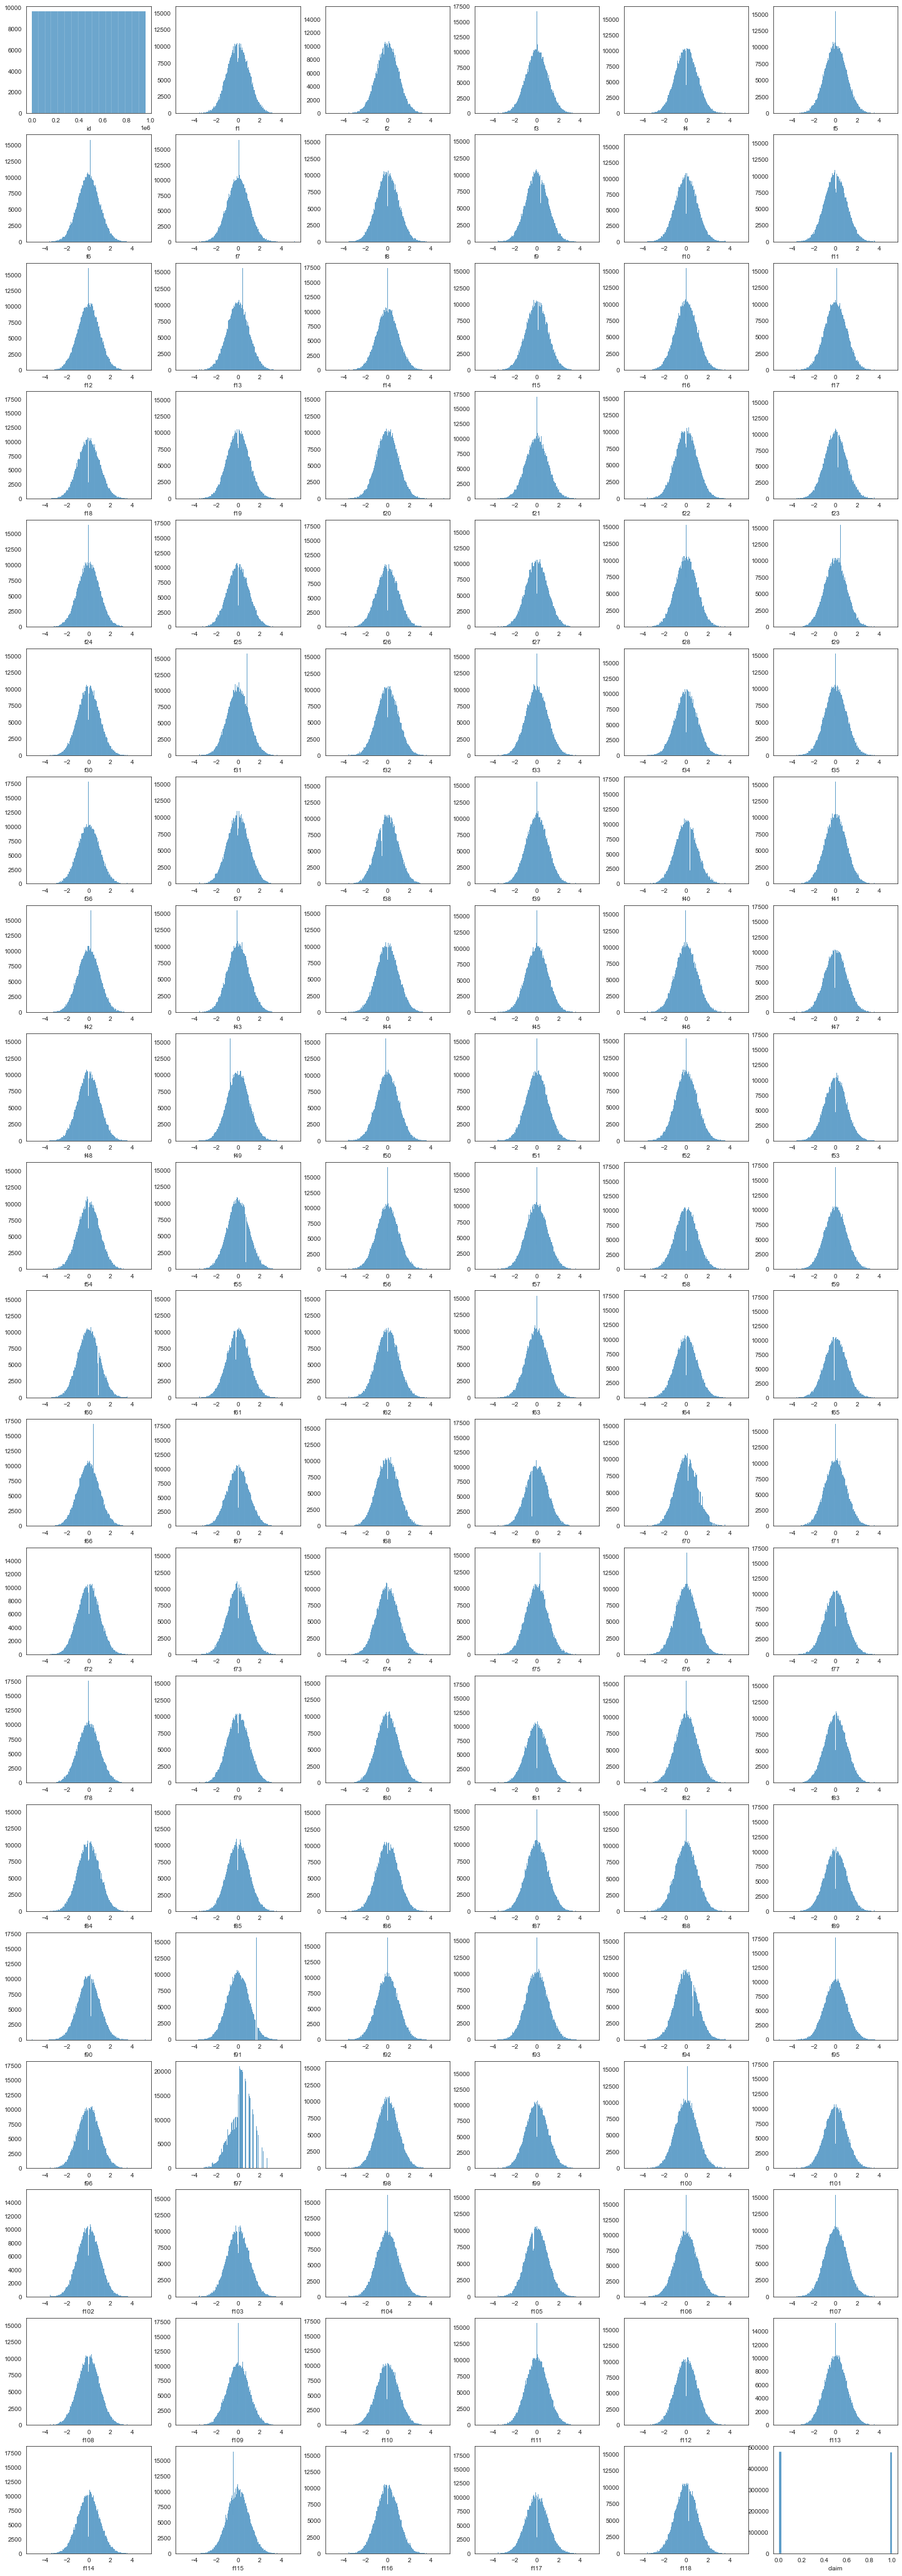

In [104]:
# 強制轉正態後分布

NROW=20
NCOL=6                                                                                
                                                                                        
i = 0
sns.set_style('white')
fig, ax = plt.subplots(NROW, NCOL, figsize = (25,75))
plot_df = train_df.reset_index()
for row in tqdm(range(NROW)):
    for col in range(NCOL):
        sns.histplot(data = plot_df.iloc[:,i], ax = ax[row, col], palette = 'bone_r').set(ylabel = '')
        i = i + 1

# palette 調色盤

# KFOLD : 穩定模型 
```python
import KFold from sklearn.model_selection                        # 連續、類別
```
參考 : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

you can also 
```python
import train_test_split from skleran.model_selection             # 連續、類別、類別不平衡
```
If your data is sensitive to cardinality (基數) of categorical
```python
import StratifiedKFold from sklearn.model_selection              # 類別、類別不平衡
```

In [6]:
# 直接用加 NaN 數量的資料

df_train = pd.read_csv(r"C:\Users\user\Desktop\2022data\na_number.csv",index_col='id')
df_test = pd.read_csv(r"C:\Users\user\Desktop\2022data\na_number_test.csv",index_col='id')

#路徑字串開頭要寫 r & 檔案名稱.csv                         
# r :為了不讓 \ 被讀成特殊字元 EX: \n
#指定欄位 id 為索引 (取代原本 0.1...957918的位置)

# df_train.isnull().sum().sum() # 還有缺失值嗎  # 1820782
# df_train.isnull().sum().sum() # 還有缺失值嗎  # 1820782

df_train.head()


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f111,f112,f113,f114,f115,f116,f117,f118,Nanumber,claim
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1,1
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0,0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,5,1
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,2,1
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,8,1


In [7]:
# K-Fold 資料

# Xtrain = train_df.copy().loc[:,'f1':'f118']
# Ytrain = train_df.copy().loc[:,'claim']
# Xtest = test_df.copy()

Xtrain = df_train.copy().loc[:,'f1':'Nanumber']     # 後面 kfold 用
Ytrain = df_train.copy().loc[:,'claim']
Xtest = df_test.copy()


## KFOLD 範例

In [8]:
# Xtrain = train_df.copy().loc[:,'f1':'f118']
# Ytrain = train_df.copy().loc[:,'claim']
# Xtest = test_df.copy()

```python
##### Set your configuration(配置) here!!

FOLD = 5                                          # 切 5 分
SEEDS = [24, 42]                                  # 要做幾次 K-fold ,這裡做 2 次

fet_imp = 0                                       # feature importance (not necessary)  # 看特徵重要性
counter = 0                                       # 整個迴圈的個數
oof_score = 0                                     # oof_score /= float(counter)，整個 kfold 的平均分數，roc_auc_score                         

##### here I use XGBoost to implement KFold, you may choose your model by your self
y_pred_final_xgb = np.zeros((Xtest.shape[0], 1))  # 建 2維 0 陣列
y_pred_meta_xgb = np.zeros((Xtrain.shape[0], 1))  

##### your chosen seeds
for sidx, seed in tqdm(enumerate(SEEDS)):         # enumerate(枚舉) : 看list物件，(0,24) 第一次 & (1,42) 第二次
    seed_score = 0                                # 累積每次 kfold 完分數，後面拿去算每次的平均分數
    
    ##### start KFold
    
    kfold = KFold(n_splits=FOLD, shuffle=True, random_state=seed)   # shuffle : 打亂，第 n 次的 random_state 
  # kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed) 

    for flod_idx, (train_idx, val_idx) in enumerate(kfold.split(Xtrain.values, Ytrain.values)): 
                                  # ('f1:f118' & 'claim') 分別對 data 跟 label 切出訓練 & 驗證集，後面 fit 用
                                  # kfold.split : 生成 index 以將數據拆分為訓練集和測試集 
                                  # KFold()方法中的 split()：split(a,b)：方法會根據折數對 a 和 b 進行劃分，返回相應數據的下標
                                  # DF --> array , Xtrain.values (957919, 118)    
        counter += 1              # 整個做到第 (kfold 裡切幾次*做幾次 kflod) 次 
        
        ##### setting sub training data and validation data
        train_x, train_y = Xtrain.iloc[train_idx], Ytrain.iloc[train_idx]     # 拿出切好的訓練 & 驗證集 (train, val)
        val_x, val_y = Xtrain.iloc[val_idx], Ytrain.iloc[val_idx]             # K-Flod 做完
        
############################################################################  # 以下以 XGBoost 為例  ####################
        ##### This is nothing to do with KFold (建)
        # params['learning_rate']=0.02                         
        # init_model = XGBClassifier(**params)                                # **params : 之前設的參數全放
        init_model = XGBClassifier(learning_rate = 0.02)                      # 建 model
        
        ##### You may fit your model here!
        init_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (val_x, val_y)], 
                       early_stopping_rounds=200, verbose=500)                
        
        ##### Ignore this block
        # params['learning_rate']=0.01
        # model = XGBClassifier(**params)
        model = XGBClassifier(learning_rate = 0.01)

        model.fit(train_x, train_y, eval_set=[(train_x, train_y), (val_x, val_y)], 
                  early_stopping_rounds=100, verbose=300, xgb_model=init_model)
        
        ##### predict validation set and testing set      # 預測 驗證集 & 測試集
        y_pred = model.predict_proba(val_x, iteration_range=(0, model.best_iteration))[:,-1]            
        y_pred_meta_xgb[val_idx] += np.array([y_pred]).T  # 第 1/5 份驗證集的預測，5次才會滿
        
        y_pred_final_xgb += np.array([model.predict_proba(Xtest, iteration_range=(0, model.best_iteration))[:,-1]]).T   
                                                          # 整個測試集的預測，一次就滿了
        
        ##### calculate your metrics here
        fet_imp += model.feature_importances_             # 樹模型特有，特徵用越多次越重要
                                                          # model.feature_importances_ : 每次特徵的重要性(比例)，總和約為 1
        score = roc_auc_score(val_y, y_pred)              # 算 roc_auc 分數
        oof_score += score                                # 把整個分數加到底
        seed_score += score                               # 累積每次 kfold 完的分數
        
        ##### metric logger (指標記錄器)
        print("\n Seed-{} | Fold-{} | OOF Score: {} \n".format(seed, flod_idx, score))    
                                                          # 此次(24 & 42)，第 (flod_idx + 1) 個 kfold.split，評分
    
    print("\n Seed: {} | Aggregate OOF Score: {} \n\n".format(seed, (seed_score / FOLD)))   
                                                          # 此次 random_state，的平均指標分數


fet_imp = fet_imp / float(counter)                     # 整個 Kfold 中的特徵重要性(比例)，總和約為 1
y_pred_meta_xgb = y_pred_meta_xgb / float(len(SEEDS))  # 驗證集的預測 / 做幾次 kfold                      (平均一次驗證集)
y_pred_final_xgb = y_pred_final_xgb / float(counter)   # 整個測試集的預測 / (kfold 裡切幾次*做幾次 kflod)  (平均一次測試集)
oof_score /= float(counter)                            # (整個分數加到底 / 整個次數)，整個 kfold 的平均分數，roc_auc_score 

print("Aggregate OOF Score: {}".format(oof_score))

```

**early_stopping_rounds=200**
```
在到達之前停止，如果它已經轉了200圈而指標沒有改進。

early_stopping_rounds參數應位於 .fit() 中
```
**verbose=500**
```
用來控制在訓練過程中返回信息的詳細程度。

verbose=0，就是訓練時不返回任何信息
verbose=1，訓練時返回一些信息
verbose=2，返回訓練步驟的詳細信息。

詳細級別：如果非零，則打印進度消息。高於 50，輸出發送到標準輸出。
         消息的頻率隨著詳細級別的增加而增加。如果超過 10，則報告所有迭代。

```
參考 : https://stackoverflow.com/questions/29995249/verbose-argument-in-scikit-learn

**model.predict_proba() : 返回所有標籤值可能性概率值**
```
返回的預測值為獲得所有結果的概率。

有多少個分類結果，每行就有多少個概率，對每個結果都有一個概率值，

如 0、1 兩分類就有兩個概率，預測為 0 類的概率值和預測為 1 的概率值和為 1

這些值是如何排序的呢？

返回模型中每個類的樣本概率，其中類按類self.classes_進行排序。

通過numpy.unique(label)方法，對label中的所有標籤值進行從小到大的重排序。

得到一個從小到大唯一值的排序，對應於model.predict_proba()的行返回結果
```
原文：https://blog.csdn.net/weixin_39918961/article/details/111755153

In [15]:
a = [4,8,9]
for i in enumerate(a):        # enumerate(枚舉) : (順序,物件) ,看list物件  
    print(i)

(0, 4)
(1, 8)
(2, 9)


In [9]:
xgb_params1 = {
    'eval_metric': 'auc', 
    'objective': 'binary:logistic',           # loss function
    'tree_method': 'gpu_hist', 
    'gpu_id': -1, 
    'predictor': 'gpu_predictor', 
    'n_estimators': 10000,                    # 樹的數量
    'learning_rate': 0.01,                    # 樹的學習率
    'gamma': 0.2465,                          # Loss function 下降的下界 (越大越保守)
    'max_depth': 4,                           # 預剪枝，樹的最大深度
    'min_child_weight': 366,                  # 預剪枝，樹的子結點最小樣本合
    'subsample': 0.6423,                      # 樣本抽樣比例
    'colsample_bytree': 0.775,                # 特徵抽樣比例
    'colsample_bylevel': 0.868,               # 結點使用特徵比例
    'lambda': 0.5,                            # L2正則懲罰項
    'alpha': 10,                              # L1正則懲罰項
    'random_state': 42,
    'use_label_encoder': False
}

In [10]:
xgb_params.values()                                                           
                                                                                 ####################################
                                                                                 #### 能直接用字典指定所有參數嗎 ? ####
                                                                                 ####################################
# 可以，用 **xgb_params                                                           ####################################
        

dict_values(['auc', 'binary:logistic', 'gpu_hist', -1, 'gpu_predictor', 10000, 0.02, 0.2465, 4, 366, 0.6423, 0.775, 0.868, 0.5, 10, 42, False])

In [11]:
# eval_set=[(train_x, train_y), (val_x, val_y)]
# evaluation : 評估

# iteration_range=(0, model.best_iteration))

###########################################################################################################################

# 後面 verbose=300 輸出的內容跟設定的 'eval_metric': 'auc' 有關，要去看內建預設是啥


In [12]:
# Xtest & Xtrain 上面定義 

##### Set your configuration(配置) here!!

FOLD = 5                                          # 切 5 分
SEEDS = [24, 42]                                  # 要做幾次 K-fold ,做 2次              

fet_imp = 0                                       # feature importance (not necessary)   # 看特徵重要性
counter = 0                                       # 整個迴圈的個數
oof_score = 0                                     # oof_score /= float(counter)，整個 kfold 的平均分數，roc_auc_score  

##### here I use XGBoost to implement KFold, you may choose your model by your self
y_pred_final_xgb = np.zeros((Xtest.shape[0], 1))  # 建 2維 0 陣列
y_pred_meta_xgb = np.zeros((Xtrain.shape[0], 1))   

##### your chosen seeds
for sidx, seed in tqdm(enumerate(SEEDS)):         # enumerate(枚舉) : 看list物件，(0,24) 第一次 & (1,42) 第二次   
    seed_score = 0                                # 累積每次 kfold 完分數，後面拿去算每次的平均分數
    
    ##### start KFold
    
    kfold = KFold(n_splits=FOLD, shuffle=True, random_state=seed)              # shuffle : 打亂，第 n 次的 random_state
  # kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed) 

    for flod_idx, (train_idx, val_idx) in enumerate(kfold.split(Xtrain.values, Ytrain.values)):
                                                  # ('f1:f118' & 'claim') 分別對 data 跟 label 切出訓練 & 驗證集，後面 fit 用
                                                  # kfold.split : 生成 index 以將數據拆分為訓練集和測試集 
                                                  # KFold()方法中的 split()：split(a,b)：方法會根據折數對 a 和 b 進行劃分，返回相應數據的下標
                                                  # DF --> array , Xtrain.values (957919, 118)
        counter += 1                              # 整個做到第 (kfold 裡切幾次*做幾次 kflod) 次                        
        
        ##### setting sub training data and validation data
        train_x, train_y = Xtrain.iloc[train_idx], Ytrain.iloc[train_idx]      # 拿出切好的訓練 & 驗證集 (train, val)
        val_x, val_y = Xtrain.iloc[val_idx], Ytrain.iloc[val_idx]              # K-Flod 做完
        
#############################################################################  # 以下以 XGBoost 為例  ###########################
        ##### This is nothing to do with KFold (建)
        # params['learning_rate']=0.02 
        # init_model = XGBClassifier(**params)                                 # **params : 之前設的參數全放
        init_model = XGBClassifier(**xgb_params)                       # 建 model
        
        ##### You may fit your model here!
        init_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (val_x, val_y)], early_stopping_rounds=200, verbose=500)
                                                                           
        ##### Ignore this block 
        # params['learning_rate']=0.01
        # model = XGBClassifier(**params)
        model = XGBClassifier(**xgb_params1)

        model.fit(train_x, train_y, eval_set=[(train_x, train_y), (val_x, val_y)], early_stopping_rounds=100, verbose=300, xgb_model=init_model)
        
        ##### predict validation set and testing set                                            # 預測 驗證集 & 測試集
        y_pred = model.predict_proba(val_x, iteration_range=(0, model.best_iteration))[:,-1]    # 預測最後一類的機率
        y_pred_meta_xgb[val_idx] += np.array([y_pred]).T                                        # 第 1/5 份驗證集的預測，5次才會滿    
    
        y_pred_final_xgb += np.array([model.predict_proba(Xtest, iteration_range=(0, model.best_iteration))[:,-1]]).T 
                                                                                                # 整個測試集的預測
        
        ##### calculate your metrics here
        fet_imp += model.feature_importances_          # 樹模型特有，特徵用越多次越重要 
                                                       # model.feature_importances_ : 每次特徵的重要性(比例)，總和約為 1
        score = roc_auc_score(val_y, y_pred)           # 算 roc_auc 分數
        oof_score += score                             # 把整個分數加到底
        seed_score += score                            # 累積每次 kfold 完的分數
        
        ##### metric logger (指標記錄器)
        print("\nSeed-{} | Fold-{} | OOF Score: {}\n".format(seed, flod_idx, score)) 
                                                       # 此次(24 & 42)，第 (flod_idx + 1) 個 kfold.split，評分
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))  
                                                       # 此次 random_state，的平均指標分數


fet_imp = fet_imp / float(counter)                     # 整個 Kfold 中的特徵重要性(比例)，總和約為 1
y_pred_meta_xgb = y_pred_meta_xgb / float(len(SEEDS))  # 驗證集的預測 / 做幾次 kfold  (平均一次驗證集)
y_pred_final_xgb = y_pred_final_xgb / float(counter)   # 整個測試集的預測 / (kfold 裡切幾次*做幾次 kflod)  (平均一次測試集)
oof_score /= float(counter)                            # (整個分數加到底 / 整個次數)，整個 kfold 的平均分數，roc_auc_score 

print("Aggregate OOF Score: {}".format(oof_score))


0it [00:00, ?it/s]C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.53078	validation_1-auc:0.52940
[500]	validation_0-auc:0.81729	validation_1-auc:0.81070
[1000]	validation_0-auc:0.82161	validation_1-auc:0.81285
[1500]	validation_0-auc:0.82441	validation_1-auc:0.81385
[2000]	validation_0-auc:0.82683	validation_1-auc:0.81450
[2500]	validation_0-auc:0.82913	validation_1-auc:0.81487
[3000]	validation_0-auc:0.83135	validation_1-auc:0.81513
[3500]	validation_0-auc:0.83356	validation_1-auc:0.81527
[4000]	validation_0-auc:0.83573	validation_1-auc:0.81537
[4500]	validation_0-auc:0.83785	validation_1-auc:0.81546
[4969]	validation_0-auc:0.83981	validation_1-auc:0.81549
[0]	validation_0-auc:0.83982	validation_1-auc:0.81549
[300]	validation_0-auc:0.84041	validation_1-auc:0.81551
[600]	validation_0-auc:0.84102	validation_1-auc:0.81556
[688]	validation_0-auc:0.84120	validation_1-auc:0.81556

Seed-24 | Fold-0 | OOF Score: 0.8155626214092795



C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.53087	validation_1-auc:0.52945
[500]	validation_0-auc:0.81756	validation_1-auc:0.81003
[1000]	validation_0-auc:0.82185	validation_1-auc:0.81211
[1500]	validation_0-auc:0.82459	validation_1-auc:0.81322
[2000]	validation_0-auc:0.82689	validation_1-auc:0.81391
[2500]	validation_0-auc:0.82918	validation_1-auc:0.81433
[3000]	validation_0-auc:0.83135	validation_1-auc:0.81454
[3500]	validation_0-auc:0.83357	validation_1-auc:0.81479
[4000]	validation_0-auc:0.83569	validation_1-auc:0.81504
[4500]	validation_0-auc:0.83790	validation_1-auc:0.81515
[5000]	validation_0-auc:0.83996	validation_1-auc:0.81522
[5500]	validation_0-auc:0.84199	validation_1-auc:0.81530
[6000]	validation_0-auc:0.84396	validation_1-auc:0.81538
[6386]	validation_0-auc:0.84551	validation_1-auc:0.81541
[0]	validation_0-auc:0.84552	validation_1-auc:0.81541
[130]	validation_0-auc:0.84578	validation_1-auc:0.81541

Seed-24 | Fold-1 | OOF Score: 0.8154133512796227



C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.53102	validation_1-auc:0.53005
[500]	validation_0-auc:0.81679	validation_1-auc:0.81151
[1000]	validation_0-auc:0.82121	validation_1-auc:0.81384
[1500]	validation_0-auc:0.82409	validation_1-auc:0.81484
[2000]	validation_0-auc:0.82645	validation_1-auc:0.81538
[2500]	validation_0-auc:0.82872	validation_1-auc:0.81573
[3000]	validation_0-auc:0.83100	validation_1-auc:0.81602
[3500]	validation_0-auc:0.83325	validation_1-auc:0.81625
[4000]	validation_0-auc:0.83541	validation_1-auc:0.81643
[4500]	validation_0-auc:0.83753	validation_1-auc:0.81652
[5000]	validation_0-auc:0.83965	validation_1-auc:0.81657
[5425]	validation_0-auc:0.84142	validation_1-auc:0.81659
[0]	validation_0-auc:0.84142	validation_1-auc:0.81659
[300]	validation_0-auc:0.84203	validation_1-auc:0.81661
[600]	validation_0-auc:0.84265	validation_1-auc:0.81664
[784]	validation_0-auc:0.84304	validation_1-auc:0.81665

Seed-24 | Fold-2 | OOF Score: 0.8166517660497561



C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.53078	validation_1-auc:0.53039
[500]	validation_0-auc:0.81711	validation_1-auc:0.81209
[1000]	validation_0-auc:0.82155	validation_1-auc:0.81411
[1500]	validation_0-auc:0.82436	validation_1-auc:0.81504
[2000]	validation_0-auc:0.82665	validation_1-auc:0.81555
[2500]	validation_0-auc:0.82896	validation_1-auc:0.81595
[3000]	validation_0-auc:0.83122	validation_1-auc:0.81628
[3500]	validation_0-auc:0.83345	validation_1-auc:0.81645
[4000]	validation_0-auc:0.83564	validation_1-auc:0.81661
[4500]	validation_0-auc:0.83782	validation_1-auc:0.81668
[5000]	validation_0-auc:0.83991	validation_1-auc:0.81680
[5332]	validation_0-auc:0.84132	validation_1-auc:0.81684
[0]	validation_0-auc:0.84132	validation_1-auc:0.81684
[111]	validation_0-auc:0.84156	validation_1-auc:0.81684

Seed-24 | Fold-3 | OOF Score: 0.8168427170661674



C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.53080	validation_1-auc:0.52955
[500]	validation_0-auc:0.81714	validation_1-auc:0.81043
[1000]	validation_0-auc:0.82160	validation_1-auc:0.81276
[1500]	validation_0-auc:0.82440	validation_1-auc:0.81378
[2000]	validation_0-auc:0.82680	validation_1-auc:0.81433
[2500]	validation_0-auc:0.82907	validation_1-auc:0.81474
[3000]	validation_0-auc:0.83133	validation_1-auc:0.81508
[3500]	validation_0-auc:0.83353	validation_1-auc:0.81528
[4000]	validation_0-auc:0.83574	validation_1-auc:0.81544
[4500]	validation_0-auc:0.83786	validation_1-auc:0.81558
[5000]	validation_0-auc:0.83997	validation_1-auc:0.81566
[5500]	validation_0-auc:0.84205	validation_1-auc:0.81569
[6000]	validation_0-auc:0.84409	validation_1-auc:0.81577
[6500]	validation_0-auc:0.84602	validation_1-auc:0.81579
[6867]	validation_0-auc:0.84745	validation_1-auc:0.81578
[0]	validation_0-auc:0.84745	validation_1-auc:0.81578
[300]	validation_0-auc:0.84804	validation_1-auc:0.81579
[329]	validation_0-auc:0.84810	validati

1it [1:26:42, 5202.41s/it]


Seed-24 | Fold-4 | OOF Score: 0.8157998414228327


Seed: 24 | Aggregate OOF Score: 0.8160540594455318




C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.53082	validation_1-auc:0.53086
[500]	validation_0-auc:0.81747	validation_1-auc:0.80952
[1000]	validation_0-auc:0.82182	validation_1-auc:0.81177
[1500]	validation_0-auc:0.82473	validation_1-auc:0.81276
[2000]	validation_0-auc:0.82714	validation_1-auc:0.81334
[2500]	validation_0-auc:0.82938	validation_1-auc:0.81372
[3000]	validation_0-auc:0.83161	validation_1-auc:0.81396
[3500]	validation_0-auc:0.83386	validation_1-auc:0.81423
[4000]	validation_0-auc:0.83602	validation_1-auc:0.81441
[4466]	validation_0-auc:0.83805	validation_1-auc:0.81450
[0]	validation_0-auc:0.83806	validation_1-auc:0.81450
[300]	validation_0-auc:0.83871	validation_1-auc:0.81453
[372]	validation_0-auc:0.83885	validation_1-auc:0.81454

Seed-42 | Fold-0 | OOF Score: 0.8145394811831754



C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.53098	validation_1-auc:0.52994
[500]	validation_0-auc:0.81682	validation_1-auc:0.81158
[1000]	validation_0-auc:0.82130	validation_1-auc:0.81375
[1500]	validation_0-auc:0.82419	validation_1-auc:0.81485
[2000]	validation_0-auc:0.82658	validation_1-auc:0.81549
[2500]	validation_0-auc:0.82881	validation_1-auc:0.81588
[3000]	validation_0-auc:0.83108	validation_1-auc:0.81614
[3500]	validation_0-auc:0.83326	validation_1-auc:0.81636
[4000]	validation_0-auc:0.83543	validation_1-auc:0.81651
[4500]	validation_0-auc:0.83761	validation_1-auc:0.81663
[5000]	validation_0-auc:0.83976	validation_1-auc:0.81677
[5500]	validation_0-auc:0.84183	validation_1-auc:0.81682
[6000]	validation_0-auc:0.84385	validation_1-auc:0.81685
[6113]	validation_0-auc:0.84430	validation_1-auc:0.81686
[0]	validation_0-auc:0.84431	validation_1-auc:0.81686
[164]	validation_0-auc:0.84463	validation_1-auc:0.81687

Seed-42 | Fold-1 | OOF Score: 0.8168704094720475



C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.53045	validation_1-auc:0.53043
[500]	validation_0-auc:0.81741	validation_1-auc:0.81057
[1000]	validation_0-auc:0.82167	validation_1-auc:0.81270
[1500]	validation_0-auc:0.82452	validation_1-auc:0.81366
[2000]	validation_0-auc:0.82695	validation_1-auc:0.81431
[2500]	validation_0-auc:0.82920	validation_1-auc:0.81471
[3000]	validation_0-auc:0.83146	validation_1-auc:0.81494
[3500]	validation_0-auc:0.83373	validation_1-auc:0.81507
[4000]	validation_0-auc:0.83590	validation_1-auc:0.81522
[4500]	validation_0-auc:0.83805	validation_1-auc:0.81527
[5000]	validation_0-auc:0.84014	validation_1-auc:0.81535
[5500]	validation_0-auc:0.84216	validation_1-auc:0.81541
[5611]	validation_0-auc:0.84263	validation_1-auc:0.81541
[0]	validation_0-auc:0.84263	validation_1-auc:0.81541
[300]	validation_0-auc:0.84326	validation_1-auc:0.81543
[600]	validation_0-auc:0.84388	validation_1-auc:0.81544
[627]	validation_0-auc:0.84394	validation_1-auc:0.81544

Seed-42 | Fold-2 | OOF Score: 0.81544448

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.53068	validation_1-auc:0.53029
[500]	validation_0-auc:0.81718	validation_1-auc:0.81130
[1000]	validation_0-auc:0.82156	validation_1-auc:0.81336
[1500]	validation_0-auc:0.82440	validation_1-auc:0.81427
[2000]	validation_0-auc:0.82677	validation_1-auc:0.81476
[2500]	validation_0-auc:0.82906	validation_1-auc:0.81510
[3000]	validation_0-auc:0.83127	validation_1-auc:0.81537
[3500]	validation_0-auc:0.83339	validation_1-auc:0.81560
[4000]	validation_0-auc:0.83553	validation_1-auc:0.81571
[4500]	validation_0-auc:0.83768	validation_1-auc:0.81576
[5000]	validation_0-auc:0.83982	validation_1-auc:0.81584
[5500]	validation_0-auc:0.84189	validation_1-auc:0.81594
[5720]	validation_0-auc:0.84281	validation_1-auc:0.81593
[0]	validation_0-auc:0.84281	validation_1-auc:0.81593
[120]	validation_0-auc:0.84306	validation_1-auc:0.81593

Seed-42 | Fold-3 | OOF Score: 0.8159317839054908



C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.53071	validation_1-auc:0.53029
[500]	validation_0-auc:0.81695	validation_1-auc:0.81157
[1000]	validation_0-auc:0.82129	validation_1-auc:0.81377
[1500]	validation_0-auc:0.82404	validation_1-auc:0.81471
[2000]	validation_0-auc:0.82646	validation_1-auc:0.81537
[2500]	validation_0-auc:0.82867	validation_1-auc:0.81582
[3000]	validation_0-auc:0.83089	validation_1-auc:0.81615
[3500]	validation_0-auc:0.83315	validation_1-auc:0.81639
[4000]	validation_0-auc:0.83531	validation_1-auc:0.81662
[4500]	validation_0-auc:0.83737	validation_1-auc:0.81674
[5000]	validation_0-auc:0.83949	validation_1-auc:0.81684
[5500]	validation_0-auc:0.84161	validation_1-auc:0.81695
[6000]	validation_0-auc:0.84363	validation_1-auc:0.81702
[6291]	validation_0-auc:0.84477	validation_1-auc:0.81702
[0]	validation_0-auc:0.84477	validation_1-auc:0.81702
[300]	validation_0-auc:0.84538	validation_1-auc:0.81705
[401]	validation_0-auc:0.84557	validation_1-auc:0.81705


2it [2:49:13, 5076.64s/it]


Seed-42 | Fold-4 | OOF Score: 0.8170461126126013


Seed: 42 | Aggregate OOF Score: 0.8159664536483534


Aggregate OOF Score: 0.8160102565469426


In [13]:
fet_imp  # 整個 Kfold 中的特徵重要性(比例)

array([0.00172414, 0.00155106, 0.00203251, 0.00154473, 0.00173112,
       0.00168783, 0.00194524, 0.00196704, 0.0017272 , 0.00149769,
       0.00211986, 0.00160399, 0.00160686, 0.00159267, 0.00168653,
       0.0020913 , 0.0018642 , 0.00146592, 0.00202597, 0.001795  ,
       0.00230284, 0.00147355, 0.00154317, 0.00173427, 0.00191752,
       0.00136726, 0.00165792, 0.00176888, 0.00169575, 0.00151164,
       0.00180208, 0.0018168 , 0.00149075, 0.00209884, 0.00211524,
       0.00172665, 0.00155694, 0.00198491, 0.0015112 , 0.00264347,
       0.00137748, 0.00164117, 0.00160117, 0.00170384, 0.00224475,
       0.00206784, 0.00230344, 0.00264654, 0.00145828, 0.00156177,
       0.00140796, 0.00175336, 0.00240137, 0.00147336, 0.00142864,
       0.00173575, 0.00214282, 0.00141074, 0.00137561, 0.00152904,
       0.00173275, 0.00171629, 0.00159653, 0.0014667 , 0.00208874,
       0.00148319, 0.00141227, 0.00143602, 0.00191752, 0.00254741,
       0.00166761, 0.00139366, 0.00168936, 0.0016706 , 0.00159

In [14]:
y_pred_meta_xgb   # 驗證集

array([[0.5696018 ],
       [0.16672591],
       [0.83546928],
       ...,
       [0.1077584 ],
       [0.56110746],
       [0.78295913]])

In [15]:
final_claim = y_pred_final_xgb  # 測試集
final_claim

array([[0.56426461],
       [0.12014151],
       [0.63373597],
       ...,
       [0.77218968],
       [0.13707313],
       [0.76664596]])

# Plot confusion matrix

confusion matrix is always a great visualization tool to justify your model performance.

**from sklearn.metrics import confusion_matrix**

參考 : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

plt .布局 : https://matplotlib.org/stable/tutorials/text/text_props.html

**import itertools**

由多種方法組成，在各種迭代器中用於計算快速且代碼高效的解決方案

參考 : https://docs.python.org/3/library/itertools.html

In [19]:
##### you may import itertools

# confusion matrix 圖的配置，把矩陣化成圖

def plot_confusion_matrix(cm, classes):

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)   # interpolation : 插值 
    plt.title('Confusion matrix', fontweight='bold', pad=15)     # 字體重量 :'bold'(粗體), pad : 標題放置距離
    
    plt.colorbar()
    tick_marks = np.arange(len(classes))                # classes : list，的長度，的 array，X 的位置
    plt.xticks(tick_marks, classes, rotation=0)         # xticks : 把坐標軸變成自己想要的樣子，類似覆蓋，覆蓋長度要和原來坐標長度一致
    plt.yticks(tick_marks, classes)                     # rotation=0 : 以度為單位的角度
                                                        # rotation='vertical' : 跟座標垂直
    
    thresh = cm.max() / 2.                              # threshold (臨界點)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                                                        # itertools.product : 兩個集合的笛卡爾積，定義為所有有序對 (a, b) 的集合
                                                        # ex : (0,0)、(0,1)、(1,0)、(1,1)
        plt.text(j, i, format(cm[i, j], 'g'),           # 'd' 十進制整數，輸出以 10 為底的數字，細節 : help('FORMATTING')
                 horizontalalignment="center",          # 水平對齊 {'center', 'right', 'left'}
                 color="white" if cm[i, j] > thresh else "black")
                                                        # 數字大於 threshold (臨界點)，給白色，因為 Blues 是淺藍到深

    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    plt.tight_layout()                                  # 調整子圖之間和周圍的填充
    

0.7735873283649244


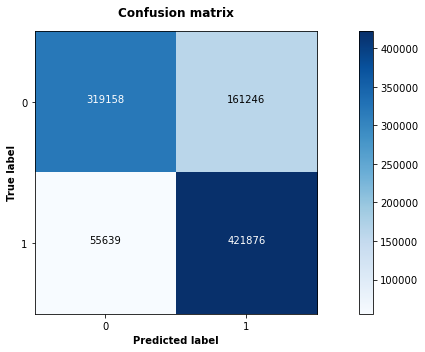

In [20]:
np.set_printoptions(precision=2)   # 矩陣輸出 2 位

cnf_matrix = confusion_matrix(Ytrain, np.round(y_pred_meta_xgb.ravel()) , labels=[0, 1])  # (957919,)，Series & array


plt.figure(figsize=(12, 5))
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

print((cnf_matrix[0,0] + cnf_matrix[1,1]) / sum(cnf_matrix).sum())
# 386282+233931=620213 / 957919 = 0.6474587099744341


0.7739177651094341


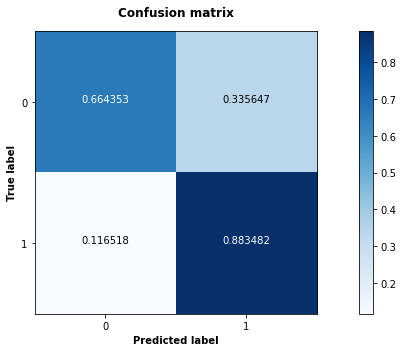

In [21]:
np.set_printoptions(precision=2)   # 矩陣輸出 2 位

cnf_matrix = confusion_matrix(Ytrain, np.round(y_pred_meta_xgb.ravel()) , labels=[0, 1])  # (957919,)，Series & array
cnf_matrix = cnf_matrix/cnf_matrix.sum(axis=1)[:,np.newaxis]                              # 轉百分比

plt.figure(figsize=(12, 5))
plot_confusion_matrix(cnf_matrix, classes=[0, 1])

print((cnf_matrix[0,0] + cnf_matrix[1,1]) / sum(cnf_matrix).sum())


**KDE plot**

<AxesSubplot:ylabel='Density'>

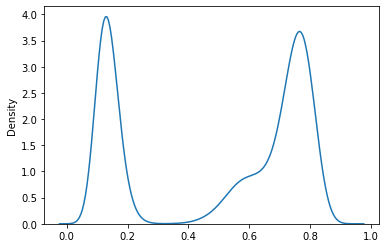

In [22]:
sns.kdeplot( final_claim.ravel() )

```python
np.set_printoptions(precision=2)   # 矩陣輸出 2 位

cnf_matrix = confusion_matrix(Ytrain, y_pred_meta_xgb.ravel(), labels=[0, 1])  

# 回傳矩陣，labels=[0, 1] : 照 0，1 順序排
# 分類指標無法處理二進制和連續目標的混合
# 只能看每次的閾值去決定每次的混淆矩陣

plt.figure(figsize=(12, 5))
plot_confusion_matrix(cnf_matrix, classes=[0, 1])
```

**Classification metrics can't handle a mix of binary and continuous targets**

- Ytrain : binary
- y_pred_meta_xgb.ravel() : continuous targets

error : https://stackoverflow.com/questions/38015181/accuracy-score-valueerror-cant-handle-mix-of-binary-and-continuous-target

In [23]:
final_claim1 = pd.DataFrame(final_claim)

In [25]:
xgboost = pd.concat((Xtest.reset_index().iloc[:,0], final_claim1), axis = 'columns')  # 需要轉 dataframe
xgboost.columns = ['id', 'xgboost']
xgboost

,id,xgboost
0,957919,0.564265
1,957920,0.120142
2,957921,0.633736
3,957922,0.125701
4,957923,0.150856
...,...,...
493469,1451388,0.819749
493470,1451389,0.109735
493471,1451390,0.772190
493472,1451391,0.137073


In [27]:
# xgboost.to_csv("C:/Users/user/Desktop/xgboost.csv") 

# 任務

```
記得加上na 數量的新feat (也可以加na 數量std)，你們必須統一 CV 的分配

念慈: (your model response should be probability instead of classification label) 
1. Fit a Logistic regression model (Select K by CV) 
2. Fit a CART model 
3. Fit a Random Forest model 

永鴻: 
1. Hyperparameter tuning and feature engineering of LightGBM (AUC should be > 0.81) 
2. LightGBM Cross Validation (you may write it from scratch) 

語謙: 
1. Hyperparameter tuning and feature engineering of XGBoost (AUC should be > 0.81) 
2. XGBoost Cross Validation (you may write it from scratch) 

TO DO: 你們做完後合力做的事情
1. Voting: (XGBoost + LightGBM + CART + Random Forest + Logistic Regression) 
2. KDE plot of each model (XGBoost, LightGBM, CART, Random Forest, Logistic Regression) 
3. Heatmap of each model (XGBoost, LightGBM, CART, Random Forest, Logistic Regression) 
4. Fit a CatBoost model 
```
CatBoost : https://ithelp.ithome.com.tw/articles/10275263
```
5. Power Averaging each model (if the correlation of heatmap > threshold (0.95))
```

# 最後參數調整

## XGBoost
```python
xgb_params = {
    'eval_metric': 'auc',                     # 用於監控訓練結果和提前停止的指標
    'objective': 'binary:logistic',           ###
    'tree_method': 'gpu_hist', 
    'gpu_id': -1, 
    'predictor': 'gpu_predictor', 
    'n_estimators': 3000,                     ### 樹的數量
    'learning_rate': 0.1,                     ### 樹的學習率
    'gamma': 0.1,                             ### Loss function 下降的下界 (越大越保守)
    'max_depth': 5,                           ### 預剪枝，樹的最大深度
    'min_child_weight': 75,                   ### 預剪枝，樹的子結點最小樣本合
    'subsample': 0.55,                        ### 樣本抽樣比例
    'colsample_bytree': 0.7,                  ### 特徵抽樣比例
    'colsample_bylevel': 0.868,               # 結點使用特徵比例
    'lambda': 0.5,                            # L2正則懲罰項
    'alpha': 10,                              # L1正則懲罰項     ### 'reg_alpha': 10
    'random_state': 42,                       ###
    'use_label_encoder': False,
    'verbosity': 0                            ###

}
```


## Light GBM
```python
gbm_params = {
    'metric' : 'auc',
    'objective' : 'binary',                   ###
    'device_type': 'gpu', 
    'n_estimators': 10000,                    ### 樹的數量
    'learning_rate': 0.095,                   ### 樹的學習率
    'num_leaves': 10,                         ### 預剪枝，葉子中樣本個數
    'max_depth': 4,                           ### 預剪枝，樹的最大深度
    'min_child_samples': 300,                 # 預剪枝，同 (min_data_in_leaf)
    'reg_alpha': 10,                          ### L1正則懲罰項
    'reg_lambda': 17,                         ### L2正則懲罰項
    'min_split_gain': 5.158,                  # 預剪枝，信息增益的下界
    'subsample': 0.5,                         ### 樣本抽樣比例
    'subsample_freq': 1,                      # 樣本抽樣頻率
    'colsample_bytree': 0.5,                  ### 特徵抽樣比例
    'min_sum_hessian_in_leaf': 1e-3,          # 預剪枝，葉子的最小 hessian 值
    'random_state': 42,                       ###
    'max_bin': 200                            ###
}
```